In [ ]:
%pip install -q ipyleaflet==0.17.3 ipywidgets==8.0.6 jupyterlab_widgets==3.0.7

# Emission Plumes

You can learn more about how to access [this data](https://dev.ghg.center/api/stac/collections/nasa-jpl-plumes-emissions-updated) directly in [the VEDA documentation](https://nasa-impact.github.io/veda-docs).

In [1]:
import json

import pandas as pd
import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl

from ipyleaflet import Map, TileLayer, GeoData, WidgetControl

In [2]:
try:
    from js import fetch

    async def fetch_json(url):
        response = await fetch(url)
        text = await response.text()
        return json.loads(text)
except: 
    import requests

    async def fetch_json(url):
        return requests.get(url).json()

In [3]:
GITHUB_URL = "https://raw.githubusercontent.com/NASA-IMPACT/veda-interactive-emission-plumes/main/content/Methane Metadata.json"
result = await fetch_json(GITHUB_URL)
df = gpd.GeoDataFrame.from_features(result["features"])

outlines = df[df.geom_type == "Polygon"].reset_index(drop=True)
centers = df[df.geom_type == "Point"].reset_index(drop=True)

In [4]:
# Get the ids for every item in the STAC collection
STAC_SEARCH_URL = "https://dev.ghg.center/api/stac/search?collections=nasa-jpl-plumes-emissions-updated&fields=id,geometry,properties&limit=1000"

result = await fetch_json(STAC_SEARCH_URL)

In [5]:
# Workaround for https://github.com/geopandas/geopandas/issues/1208
def move_id_into_props(f):
    f["properties"]["id"] = f["id"] 
    return f

result["features"] = list(map(move_id_into_props, result["features"]))
item_ids = gpd.GeoDataFrame.from_features(result["features"])

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

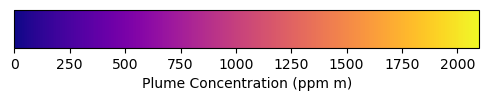

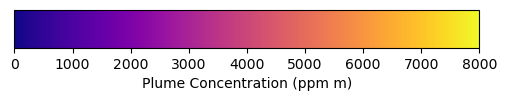

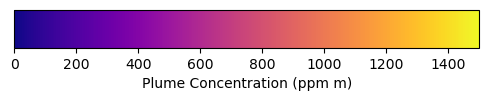

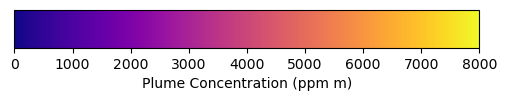

In [6]:
VMAX = 1500
IDS_ON_MAP = set()

m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True)
m.layout.min_height="800px"

polygons = GeoData(
    geo_dataframe=outlines, 
    name='outlines',
    style={"color": "red"},
    hover_style={'fillColor': 'red', "fillOpacity": 0.5},
)

pins = GeoData(
    geo_dataframe=centers, 
    name='centers',
)

out = widgets.Output(layout=widgets.Layout(width="700px"))
colorbar_widget = widgets.Output(layout=widgets.Layout(width="450px"))
vmax_fixed = widgets.Checkbox(
    description=f"Fix max value of colorbar to {VMAX} (ppm m). Click plume again to update.", 
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="450px")
)

# create date range slider and callback for filtering data
start_date = outlines["UTC Time Observed"].min().split("T")[0]
end_date = outlines["UTC Time Observed"].max().split("T")[0]

dates = [d.date().isoformat() for d in pd.date_range(start_date, end_date, freq='D')]
date_range = widgets.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    orientation='horizontal',
    layout={'width': '300px'},
    style={'description_width': 'initial'},
    readout=False
)

start_label = widgets.Label(start_date)
end_label = widgets.Label(end_date)

def filter_data(start, end):
    global outlines
    global centers
    
    index = (centers["UTC Time Observed"] > start) & (centers["UTC Time Observed"] < end)
    pins.data = json.loads(centers[index].to_json())
    polygons.data = json.loads(outlines[index].to_json())
    
def dts_callback(dts):
    start = dts[0]
    end = dts[1]
    start_label.value = start
    end_label.value = end
    filter_data(start, end)

widgets.interactive_output(dts_callback, {"dts": date_range})

date_range_widget = widgets.HBox([start_label, date_range, end_label])

m.add(polygons)
m.add(pins)
m.add(WidgetControl(widget=out, position="bottomleft"))
m.add(WidgetControl(widget=date_range_widget, position="topright"))
m.add(WidgetControl(widget=colorbar_widget, position="topright"))
m.add(WidgetControl(widget=vmax_fixed, position="topright"))

@out.capture(clear_output=True)
def display_properties(feature):
    p = {k: v for k, v in feature["properties"].items() if k not in ["style"]}
    display(pd.Series(p))
        
@colorbar_widget.capture(clear_output=True)
def create_colorbar(vmin=0, vmax=VMAX):
    colorbar_fig, ax = plt.subplots(figsize=(6, 1));
    colorbar_fig.subplots_adjust(bottom=0.5);

    cb = mpl.colorbar.ColorbarBase(
        ax, 
        cmap=mpl.cm.plasma,
        norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
        orientation='horizontal'
    );
    cb.set_label('Plume Concentration (ppm m)');
    display(colorbar_fig)
    
def add_raster(feature):
    global item_ids
    global m
    
    props = feature["properties"]

    collection = "nasa-jpl-plumes-emissions-updated"
    assets = "ch4-plume-emissions"
    vmin = 0
    vmax = VMAX if vmax_fixed.value else round(props["Max Plume Concentration (ppm m)"], -2)  # closest hundreds place
    
    if feature["id"] not in IDS_ON_MAP:
        subset = item_ids[item_ids.id.str.startswith(props["Scene FID"])]
        outline_shape = outlines.iloc[int(feature["id"])].geometry
        subset = subset[subset.intersects(outline_shape)]

        for item in subset.id:
            TILE_URL = (
                'https://dev.ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x'
                f'?collection={collection}&item={item}&assets={assets}'
                f'&resampling=bilinear&bidx=1&colormap_name=plasma&rescale={vmin}%2C{vmax}&nodata=-9999'
            )
            m.add_layer(TileLayer(url=TILE_URL, max_zoom=24, show_loading=True))
        IDS_ON_MAP.add(feature["id"])
    
    create_colorbar(vmin, vmax)
    if m.zoom < 12:
        m.center = (props['Latitude of max concentration'], props['Longitude of max concentration'])
        m.zoom = 12
    
def set_date_range(feature):
    global date_range
    
    props = feature["properties"]
    
    t = pd.Timestamp(props["UTC Time Observed"])
    date_range.value = ((t - pd.Timedelta("1D")).date().isoformat(), (t + pd.Timedelta("1D")).date().isoformat())

def on_click(event, feature, **kwargs):
    display_properties(feature)
    add_raster(feature)
    set_date_range(feature)
    
def update_vmax(event):
    IDS_ON_MAP.clear()

vmax_fixed.observe(update_vmax, names=["value"])

polygons.on_click(on_click)
pins.on_click(on_click)
m

⚠️ This visualization was created using a [jupyterlite-pyodide-kernel](https://github.com/jupyterlite/pyodide-kernel) and [voici](https://voici.readthedocs.io/en/latest/). It is rendered client-side (in your browser!) via the magic of [Wasm](https://webassembly.org/). This is an exciting and rapidly evolving space which means that this visualization is highly experimental and likely to break. ⚠️